In [1]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.optimize import curve_fit

In [2]:
KB = c.Boltzmann
hbar = c.Planck

In [52]:
def QT(T,d0, q0, alpha, omega):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, q0, alpha, omega, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

def retta(x, m, q):
    return m*x + q

def resonance(x, x0, Q, Q_c, phi0):
    num = np.exp(1j*phi0)
    den = 1 + 2*1j*Q*(x-x0)/x0
    return abs(1 - (Q/Q_c)*(num/den))

def model(x,m,q,x0,Q,Q_c,phi0):
    return retta(x,m,q) * resonance(x,x0,Q,Q_c,phi0)

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = max(y) - (max(y)-min(y)) / 2.
    minimums = x[np.where(y < half)]
    if len(minimums)==0: 
        print('Minimum not found!')
        return 0,1
    else:
        return (max(minimums) - min(minimums)),0

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def compute_chi2(func,x, y, sigma, p):
    sum = 0
    for (i,j,s) in zip(x,y,sigma):
        sum += ((j-func(i,*p))/s)**2
    return sum





def plotter(dfs, t, func, p, c, rows, columns, fill):

    fig, ax = plt.subplots(rows, columns, figsize=(30,20))

    for row in range(rows):
        for col in range(columns):
            i = row*columns + col


            chi2 = compute_chi2(func, np.array(dfs[i]['f']),np.array(dfs[i]['S21']), np.array(dfs[i]['S21'])*1e-3, p[i])
            ndof = len(dfs)
            title = [
                f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
            ]

            for (l,value) in enumerate(p[i]):
                title.append(
                    f"{value:.4f} +/- {np.diag(c[i])[l]:.4f}"
                )


            ax[row][col].scatter(np.array(dfs[i]['f'])*1e-9, np.array(dfs[i]['S21']), marker='.', s=1, label='Raw Data', color='black')
            ax[row][col].plot(np.array(dfs[i]['f'])*1e-9, func(np.array(dfs[i]['f']), *p[i]), label='Model', color='red')
            if (fill==True):
                ax[row][col].fill_between(np.array(dfs[i]['f'])*1e-9, np.array(dfs[i]['S21'])*(1-(1e-3)), np.array(dfs[i]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            ax[row][col].set_facecolor('bisque')
            ax[row][col].set_xlabel(r'$\nu$ [GHz]')
            ax[row][col].set_ylabel(r'$|S_{21}|$')
            ax[row][col].legend(title='\n'.join(title))
            ax[row][col].set_title('T: '+str(t[i]))
            ax[row][col].grid()
            fig.tight_layout()

    return fig

def read_files(dir = 'C:\\Users\\kid\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRdetection\\Instruments\\Test_data\\Sweep\\'):

    dictionaries, temps = [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            parent = dir+folder+'\\'
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as hf:
                    dic = dict()
                    for key in hf.keys():
                        group = hf[key]
                        for (key,value) in zip(group.attrs.keys(),group.attrs.values()):
                            if (key=='power' and value==-40):
                                for (j,item) in enumerate(group.items()):
                                    dic.update({item[0]: list(item[1][:])})
                                dictionaries.append(dic)
                                temps.append(float(str(folder).replace('T_','')))
                hf.close()   
    return dictionaries, temps

In [46]:
dfs, temps = read_files() 

In [47]:
par, migrads, ns = [], [], []
stima_m, stima_q, stima_x0, stima_Q, stima_Q_c, stima_phi = [], [], [], [], [], []
for (i,df) in enumerate(dfs):
    width,err = FWHM(np.array(df['f']),(np.array(df['S21'])))      
    stima_x0 = (float(np.min(np.array(df['f'])[np.where(np.array(df['S21']) == min(np.array(df['S21'])))])))
    stima_Q = (float(Q_stima(stima_x0,width)))
    stima_m =(float(((np.array(df['S21']))[0]-(np.array(df['S21']))[-1])/(np.array(df['f'])[0]-np.array(df['f'])[-1])))
    stima_q = ((np.array(df['S21']))[0] - stima_m * (np.array(df['f']))[0])
    stima_Q_c = (10600)
    stima_phi = (0.2)
    par.append([stima_m, stima_q, stima_x0, stima_Q, stima_Q_c, stima_phi])

In [59]:
m2, temps2, dfs2, popts, pcovs = [], [], [], [], []
for (i,df) in enumerate(dfs):
    try:
        #bounds = np.array([(0,0), (-np.inf,np.inf), (-np.inf,np.inf), (0,np.inf), (0,np.inf),(0,1)])
        popt, pcov = curve_fit(model, df['f'], df['S21'], p0=par[i])#, bounds=bounds, maxfev=10000)
        temps2.append(temps[i]*1e-3)
        popts.append(popt)
        pcovs.append(pcov)
        dfs2.append(df)
    except:
        pass
temps2.sort(reverse=True)

c:\Users\kid\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


IndexError: list index out of range

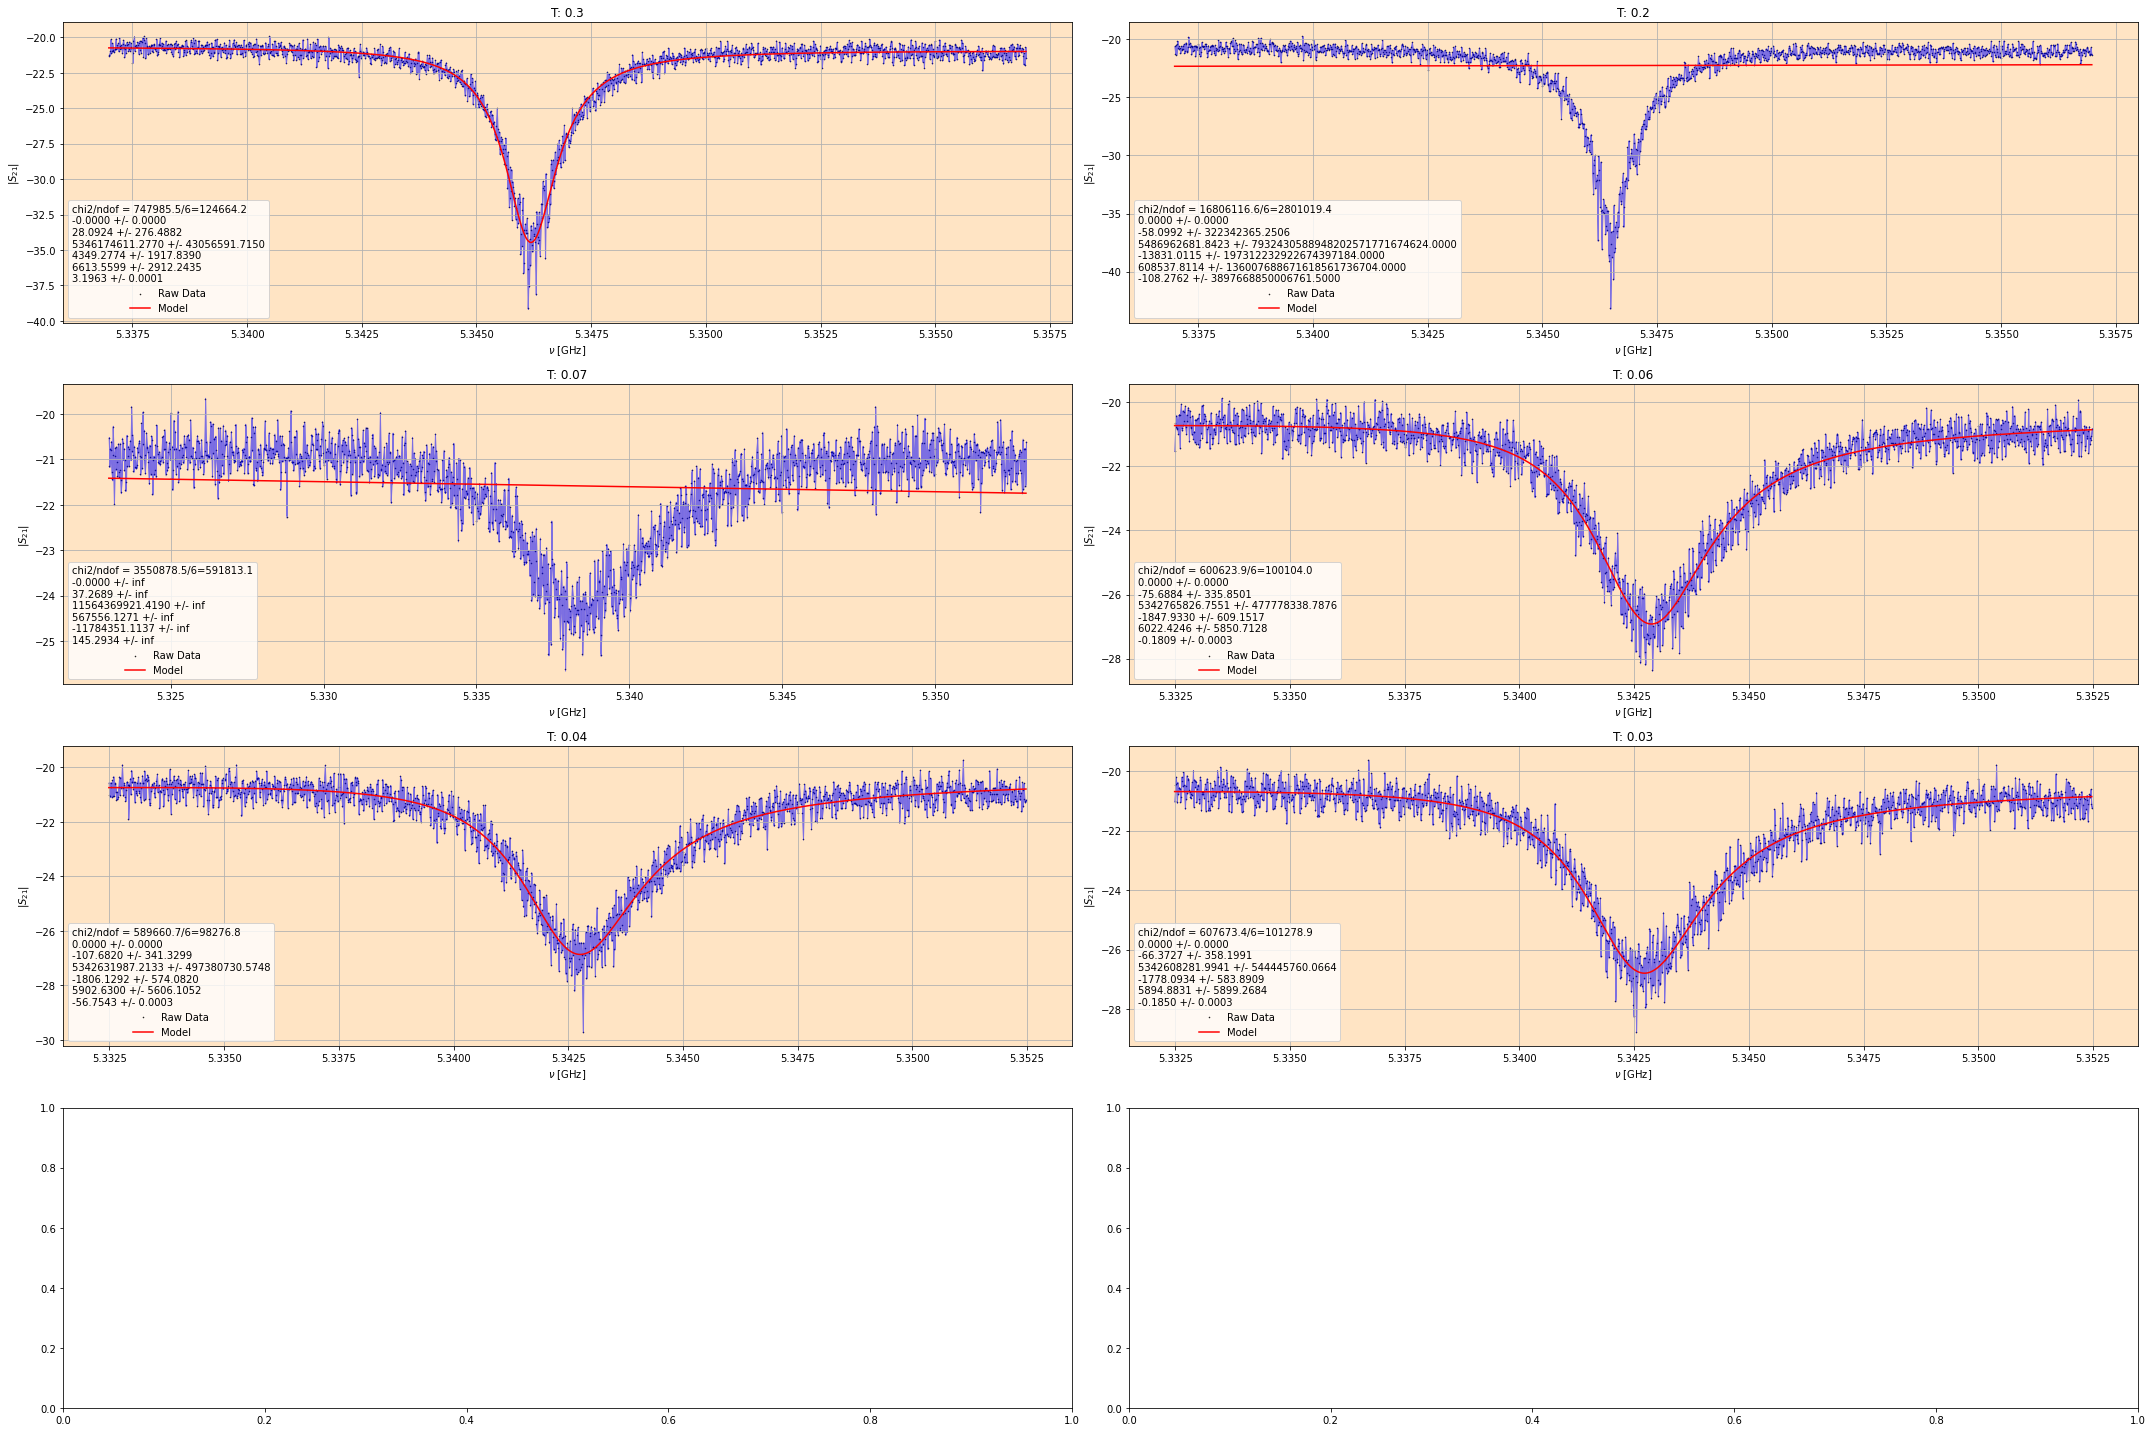

In [60]:
figure = plotter(dfs2, temps2, model, popts, pcovs, 4, 2, True)

In [54]:
x,y = [], []
for i in range(len(m2)):
    y.append(m2[i].values[2]/1e9)
    x.append(temps2[i])
x = np.array(x)
y = np.array(y)

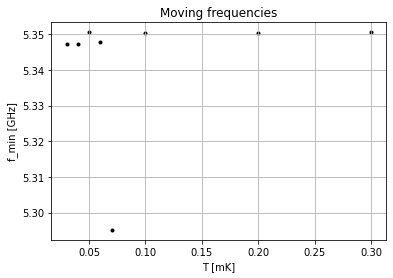

In [9]:
plt.scatter(x,y, marker='.',color='black')
plt.xlabel('T [mK]')
plt.ylabel('f_min [GHz]')
#plt.ylim([3.1774,3.1778])
plt.title('Moving frequencies')
plt.grid()

Let's create a new file with $\frac{1}{Q}$, T and $\sigma_{T}$

In [10]:
Q_invs,Q_invs_err,Qs = [], [], []
for i in range(len(temps2)):
    Qs.append(m2[i].values['Q'])
    Q_invs.append(1/(m2[i].values['Q']))
    Q_invs_err.append(1/m2[i].values['Q']**2 * m2[i].errors['Q'])
Q_invs = np.array(Q_invs)
Q_invs_err = np.array(Q_invs_err)
new_temp2 = np.array(temps2)
datas = {'T':new_temp2,'1/Q':Q_invs,'1/Q_err':Q_invs_err}
dataframe = pd.DataFrame(data=datas)
dataframe.to_csv('Fitted.csv',sep='\t',index=False)